In [2]:
import numpy as np
from dataset.utils import load_and_process_data, generate_orth, generate_fourier_kernel, generate_pendulum_specified_kernel
from dataset.pendulum_simulator import PendulumSimulatorDataset, Pendulum
from model.shallow import ModifiedShallow
from model.bilinear import ModifiedBiLinear, ModifiedBiLinear_augmented
from strategies.al_sampling import MTALSampling, MTALSampling_TaskSparse
from strategies.baseline_sampling import RandomSampling, FixBaseSampling
from trainer.pytorch_passive_trainer import PyTorchPassiveTrainer
from trainer.trainer import *
from metrics.utils import rowspace_dist, rowspace_dist2, most_related_source, sim_pendulum

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [3]:
def processName(config):
    results_name = f"embed_dim{config['embed_dim']}"
    results_name += "_active" if config["active"] else "_passive"
    results_name += "_saving_task_num" if config["saving_task_num"] else "_not_saving_task_num"
    if config["active"]:
        results_name += "_target_aware" if config["target_aware"] else "_target_agnostic"
    results_name += f"_target_sample_num{config['num_target_sample']}"
    results_name += f"_seed{config['data_seed']}"
    results_name += f"_actual_target{config['actual_target']}" if "actual_target" in config else "default"
    return results_name

<AxesSubplot: xlabel='time', ylabel='Control error'>

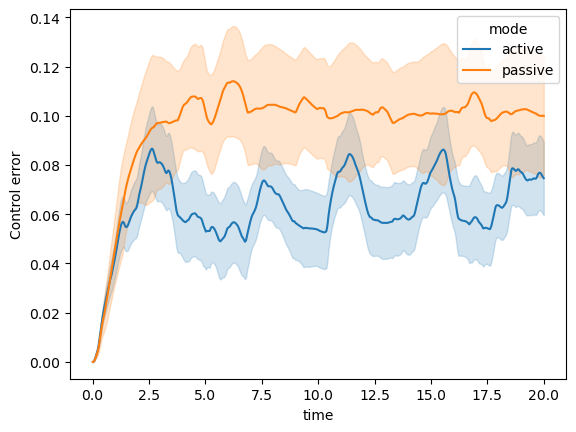

In [84]:
config = {
        "embed_dim": 8,
        "input_dim": 60,
        "num_target_sample": 5000,
        "active": None,
        "target_aware": None,
        "saving_task_num": True,
        "base_len_ratio": 1,
        "exp_base": 2,
        "outer_epoch_num": 4,
        "actual_target":  [0, 0, 0.5, 0, 0.5, 0],
        "data_seed": None
        }

actual_target = np.array(config["actual_target"])
train_model = ModifiedBiLinear_augmented(config["input_dim"], 13, config["embed_dim"], ret_emb = False).cuda()


results = None
# for seed in [ 43, 500, 12434, 425, 987, 26794, 56, 89, 1111, 89731, 21312]:
for seed in [43,500, 12434,425, 987, 26794, 56, 89, 1111,]:
    for active in [True, False]:
        config["data_seed"] = seed
        config["active"] = active
        config["target_aware"] = True if active else False
        _, _, fourier_kernel = generate_fourier_kernel(2, config["input_dim"], config["data_seed"])
        _, task_aug_kernel = generate_pendulum_specified_kernel(6, 13, seed = config["data_seed"])

        filename = processName(config)
        train_model.load_state_dict(torch.load(f"results/pendulum_nonlinear_highErrorBar/{filename}.pt"))

        def predict_from_trainedModel(x):
                aug_x = fourier_kernel(x)
                aug_x = torch.from_numpy(aug_x).float().cuda()
                train_model.eval()
                observe_target_w = np.array([[0., 0., 0., 0., 0., 1]]) 
                observe_target_w = task_aug_kernel(observe_target_w)
                observe_target_w = torch.from_numpy(observe_target_w).float().cuda()
                return train_model(aug_x, observe_target_w.T, ret_feat_and_label=False).cpu().detach().numpy()

        pendulum = Pendulum(duration=20, w=actual_target, policy_type="learned", learned_F_model = predict_from_trainedModel, noise_var=0.05, seed= 43 + 2343)
        result = sim_pendulum(pendulum, plot=False, save_path=f"results/pendulum_nonlinear_highErrorBar/{filename}.png")
        result["mode"] = "active" if active else "passive"
        result["seed"] = seed
        result = pd.DataFrame(result)
        if results is None:
                results = result
        else:
                results = pd.concat([results, result])

results["Control error"] = results["Theta"].abs()
sns.lineplot(x="time", y="Control error", data=results, errorbar=('se',1),hue="mode", markers=True, dashes=False)

<AxesSubplot: xlabel='time', ylabel='Control error'>

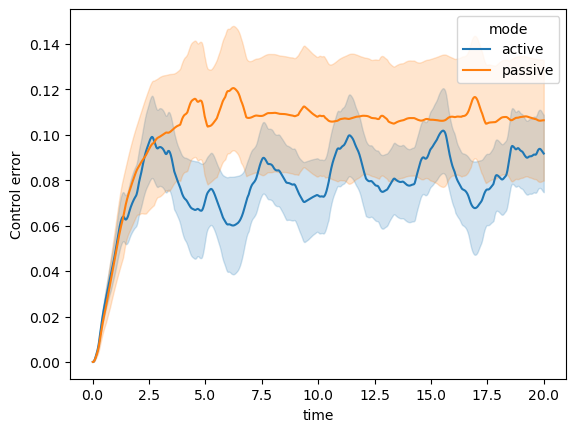

In [85]:
config = {
        "embed_dim": 8,
        "input_dim": 60,
        "num_target_sample": 5000,
        "active": None,
        "target_aware": None,
        "saving_task_num": True,
        "base_len_ratio": 1,
        "exp_base": 2,
        "outer_epoch_num": 4,
        "actual_target":  [0, 0, 1, 0.5, 0, 0],
        "data_seed": None
        }

actual_target = np.array(config["actual_target"])
train_model = ModifiedBiLinear_augmented(config["input_dim"], 13, config["embed_dim"], ret_emb = False).cuda()


results = None
# for seed in [ 43, 500, 12434, 425, 987, 26794, 56, 89, 1111, 89731, 21312]:
for seed in [43,500,12434, 425, 987, 26794, 56, 89, 1111,]:
    for active in [True, False]:
        config["data_seed"] = seed
        config["active"] = active
        config["target_aware"] = True if active else False
        _, _, fourier_kernel = generate_fourier_kernel(2, config["input_dim"], config["data_seed"])
        _, task_aug_kernel = generate_pendulum_specified_kernel(6, 13, seed = config["data_seed"])

        filename = processName(config)
        train_model.load_state_dict(torch.load(f"results/pendulum_nonlinear_highErrorBar/{filename}.pt"))

        def predict_from_trainedModel(x):
                aug_x = fourier_kernel(x)
                aug_x = torch.from_numpy(aug_x).float().cuda()
                train_model.eval()
                observe_target_w = np.array([[0., 0., 0., 0., 0., 1]]) 
                observe_target_w = task_aug_kernel(observe_target_w)
                observe_target_w = torch.from_numpy(observe_target_w).float().cuda()
                return train_model(aug_x, observe_target_w.T, ret_feat_and_label=False).cpu().detach().numpy()

        pendulum = Pendulum(duration=20, w=actual_target, policy_type="learned", learned_F_model = predict_from_trainedModel, noise_var=0.05, seed= 43 + 2343)
        result = sim_pendulum(pendulum, plot=False, save_path=f"results/pendulum_nonlinear_highErrorBar/{filename}.png")
        result["mode"] = "active" if active else "passive"
        result["seed"] = seed
        result = pd.DataFrame(result)
        if results is None:
                results = result
        else:
                results = pd.concat([results, result])

results["Control error"] = results["Theta"].abs()
sns.lineplot(x="time", y="Control error", data=results, errorbar=('se',1),hue="mode", markers=True, dashes=False)

<AxesSubplot: xlabel='time', ylabel='Control error'>

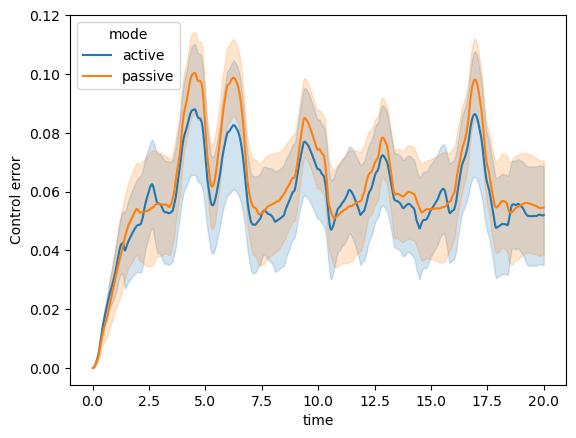

In [86]:
config = {
        "embed_dim": 8,
        "input_dim": 60,
        "num_target_sample": 5000,
        "active": None,
        "target_aware": None,
        "saving_task_num": True,
        "base_len_ratio": 1,
        "exp_base": 2,
        "outer_epoch_num": 4,
        "actual_target":  [0, -1, 0.5, 0, 0.5, 0],
        "data_seed": None
        }

actual_target = np.array(config["actual_target"])
train_model = ModifiedBiLinear_augmented(config["input_dim"], 13, config["embed_dim"], ret_emb = False).cuda()


results = None
# for seed in [ 43, 500, 12434, 425, 987, 26794, 56, 89, 1111, 89731, 21312]:
for seed in [43, 500, 12434,425, 987, 26794, 56, 89, 1111,]:
    for active in [True, False]:
        config["data_seed"] = seed
        config["active"] = active
        config["target_aware"] = True if active else False
        _, _, fourier_kernel = generate_fourier_kernel(2, config["input_dim"], config["data_seed"])
        _, task_aug_kernel = generate_pendulum_specified_kernel(6, 13, seed = config["data_seed"])

        filename = processName(config)
        train_model.load_state_dict(torch.load(f"results/pendulum_nonlinear_highErrorBar/{filename}.pt"))

        def predict_from_trainedModel(x):
                aug_x = fourier_kernel(x)
                aug_x = torch.from_numpy(aug_x).float().cuda()
                train_model.eval()
                observe_target_w = np.array([[0., 0., 0., 0., 0., 1]]) 
                observe_target_w = task_aug_kernel(observe_target_w)
                observe_target_w = torch.from_numpy(observe_target_w).float().cuda()
                return train_model(aug_x, observe_target_w.T, ret_feat_and_label=False).cpu().detach().numpy()

        pendulum = Pendulum(duration=20, w=actual_target, policy_type="learned", learned_F_model = predict_from_trainedModel, noise_var=0.05, seed= 43 + 2343)
        result = sim_pendulum(pendulum, plot=False, save_path=f"results/pendulum_nonlinear_highErrorBar/{filename}.png")
        result["mode"] = "active" if active else "passive"
        result["seed"] = seed
        result = pd.DataFrame(result)
        if results is None:
                results = result
        else:
                results = pd.concat([results, result])

results["Control error"] = results["Theta"].abs()
sns.lineplot(x="time", y="Control error", data=results, errorbar=('se',1),hue="mode", markers=True, dashes=False)

<AxesSubplot: xlabel='time', ylabel='Control error'>

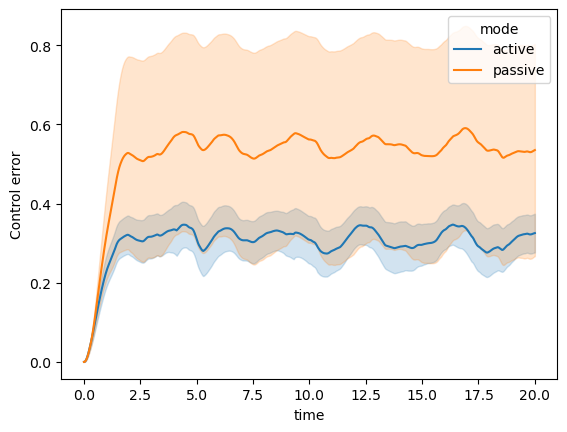

In [87]:
config = {
        "embed_dim": 8,
        "input_dim": 60,
        "num_target_sample": 5000,
        "active": None,
        "target_aware": None,
        "saving_task_num": True,
        "base_len_ratio": 1,
        "exp_base": 2,
        "outer_epoch_num": 4,
        "actual_target":  [1, 0, 0, 0.5, 0, 0],
        "data_seed": None
        }

actual_target = np.array(config["actual_target"])
train_model = ModifiedBiLinear_augmented(config["input_dim"], 13, config["embed_dim"], ret_emb = False).cuda()


results = None
# for seed in [ 43, 500, 12434, 425, 987, 26794, 56, 89, 1111, 89731, 21312]:
for seed in [43,500,12434,425, 987, 26794, 56, 89, 1111,]:
    for active in [True, False]:
        config["data_seed"] = seed
        config["active"] = active
        config["target_aware"] = True if active else False
        _, _, fourier_kernel = generate_fourier_kernel(2, config["input_dim"], config["data_seed"])
        _, task_aug_kernel = generate_pendulum_specified_kernel(6, 13, seed = config["data_seed"])

        filename = processName(config)
        train_model.load_state_dict(torch.load(f"results/pendulum_nonlinear_highErrorBar/{filename}.pt"))

        def predict_from_trainedModel(x):
                aug_x = fourier_kernel(x)
                aug_x = torch.from_numpy(aug_x).float().cuda()
                train_model.eval()
                observe_target_w = np.array([[0., 0., 0., 0., 0., 1]]) 
                observe_target_w = task_aug_kernel(observe_target_w)
                observe_target_w = torch.from_numpy(observe_target_w).float().cuda()
                return train_model(aug_x, observe_target_w.T, ret_feat_and_label=False).cpu().detach().numpy()

        pendulum = Pendulum(duration=20, w=actual_target, policy_type="learned", learned_F_model = predict_from_trainedModel, noise_var=0.05, seed= 43 + 2343)
        result = sim_pendulum(pendulum, plot=False, save_path=f"results/pendulum_nonlinear_highErrorBar/{filename}.png")
        result["mode"] = "active" if active else "passive"
        result["seed"] = seed
        result = pd.DataFrame(result)
        if results is None:
                results = result
        else:
                results = pd.concat([results, result])

results["Control error"] = results["Theta"].abs()
sns.lineplot(x="time", y="Control error", data=results, errorbar=('se',1),hue="mode", markers=True, dashes=False)

<AxesSubplot: xlabel='time', ylabel='Control error'>

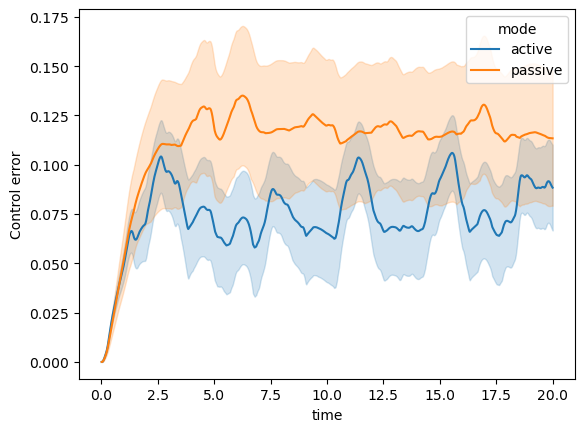

In [88]:
config = {
        "embed_dim": 8,
        "input_dim": 60,
        "num_target_sample": 5000,
        "active": None,
        "target_aware": None,
        "saving_task_num": True,
        "base_len_ratio": 1,
        "exp_base": 2,
        "outer_epoch_num": 4,
        "actual_target":  [0, 0.1, 0, -1, 0.5, 0],
        "data_seed": None
        }

actual_target = np.array(config["actual_target"])
train_model = ModifiedBiLinear_augmented(config["input_dim"], 13, config["embed_dim"], ret_emb = False).cuda()


results = None
# for seed in [ 43, 500, 12434, 425, 987, 26794, 56, 89, 1111, 89731, 21312]:
for seed in [43, 500,12434,425, 987, 26794, 56, 89, 1111,]:
    for active in [True, False]:
        config["data_seed"] = seed
        config["active"] = active
        config["target_aware"] = True if active else False
        _, _, fourier_kernel = generate_fourier_kernel(2, config["input_dim"], config["data_seed"])
        _, task_aug_kernel = generate_pendulum_specified_kernel(6, 13, seed = config["data_seed"])

        filename = processName(config)
        train_model.load_state_dict(torch.load(f"results/pendulum_nonlinear_highErrorBar/{filename}.pt"))

        def predict_from_trainedModel(x):
                aug_x = fourier_kernel(x)
                aug_x = torch.from_numpy(aug_x).float().cuda()
                train_model.eval()
                observe_target_w = np.array([[0., 0., 0., 0., 0., 1]]) 
                observe_target_w = task_aug_kernel(observe_target_w)
                observe_target_w = torch.from_numpy(observe_target_w).float().cuda()
                return train_model(aug_x, observe_target_w.T, ret_feat_and_label=False).cpu().detach().numpy()

        pendulum = Pendulum(duration=20, w=actual_target, policy_type="learned", learned_F_model = predict_from_trainedModel, noise_var=0.05, seed= 43 + 2343)
        result = sim_pendulum(pendulum, plot=False, save_path=f"results/pendulum_nonlinear_highErrorBar/{filename}.png")
        result["mode"] = "active" if active else "passive"
        result["seed"] = seed
        result = pd.DataFrame(result)
        if results is None:
                results = result
        else:
                results = pd.concat([results, result])

results["Control error"] = results["Theta"].abs()
sns.lineplot(x="time", y="Control error", data=results, errorbar=('se',1),hue="mode", markers=True, dashes=False)